# TF-MoDISco on the TAL GATA simulation

This notebook demonstrates running TF-MoDISco on importance scores obtained from the TAL-GATA simulation used in the DeepLIFT paper. See `Generate Importance Scores.ipynb` for a notebook demonstrating how to produce the scores. There are 3 tasks. Task 0 is positive when both TAL and GATA motifs are present in the sequence. Task 1 is positive when GATA motifs are present in the sequence. Task 2 is positive when TAL motifs are present in the sequence.

In [1]:
from __future__ import print_function, division
%matplotlib inline

try:
    reload  # Python 2.7
except NameError:
    try:
        from importlib import reload  # Python 3.4+
    except ImportError:
        from imp import reload  # Python 3.0 - 3.3

In [2]:
import numpy as np
import modisco
import sys
print (sys.version)
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "4"

Couldn't import dot_parser, loading of dot files will not be possible.
2.7.12 |Anaconda 2.1.0 (x86_64)| (default, Jul  2 2016, 17:43:17) 
[GCC 4.2.1 (Based on Apple Inc. build 5658) (LLVM build 2336.11.00)]


TF-MoDISco is using the TensorFlow backend.


## Grab the input data

In [3]:
!./grab_scores_for_modisco.sh

File scores.h5 exists already
File sequences.simdata.gz exists already
File test.txt.gz exists already


### Functions for one-hot encoding sequences

In [4]:
import gzip

def one_hot_encode_along_channel_axis(sequence):
    to_return = np.zeros((len(sequence),4), dtype=np.int8)
    seq_to_one_hot_fill_in_array(zeros_array=to_return,
                                 sequence=sequence, one_hot_axis=1)
    return to_return

def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1): 
        assert zeros_array.shape[0] == len(sequence)
    #will mutate zeros_array
    for (i,char) in enumerate(sequence):
        if (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        elif (char=="N" or char=="n"):
            continue #leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            zeros_array[char_idx,i] = 1
        elif (one_hot_axis==1):
            zeros_array[i,char_idx] = 1

#read in the data in the testing set
test_ids_fh = gzip.open("test.txt.gz","rb")
ids_to_load = set([x.rstrip() for x in test_ids_fh])

fasta_sequences = []
for i,a_line in enumerate(gzip.open("sequences.simdata.gz","rb")):
    if (i==0):
        next
    a_line = a_line.rstrip()
    seq_id,seq_fasta,embeddings,task1,task2,task3 = a_line.split(b"\t")
    if seq_id in ids_to_load:
        fasta_sequences.append(seq_fasta.decode("utf-8"))

## Prepare the data for input into TF-MoDISCo

You need a numpy array of importance scores and hypothetical importance scores for every task.

In [5]:
import h5py
from collections import OrderedDict

task_to_scores = OrderedDict()
task_to_hyp_scores = OrderedDict()

f = h5py.File("scores.h5","r")
tasks = f["contrib_scores"].keys()
n = 100
for task in tasks:
    #Note that the sequences can be of variable lengths;
    #in this example they all have the same length (200bp) but that is
    #not necessary.
    task_to_scores[task] = [np.array(x) for x in f['contrib_scores'][task][:n]]
    task_to_hyp_scores[task] = [np.array(x) for x in f['hyp_contrib_scores'][task][:n]]

onehot_data = [one_hot_encode_along_channel_axis(seq) for seq in fasta_sequences][:n]

Double check by plotting

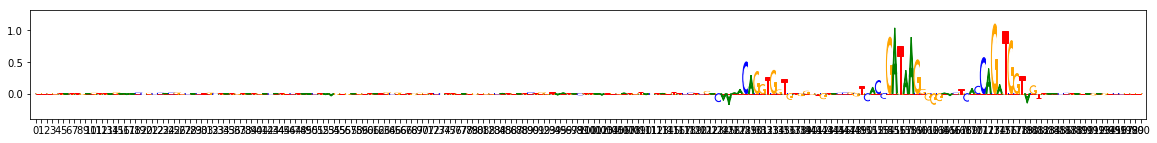

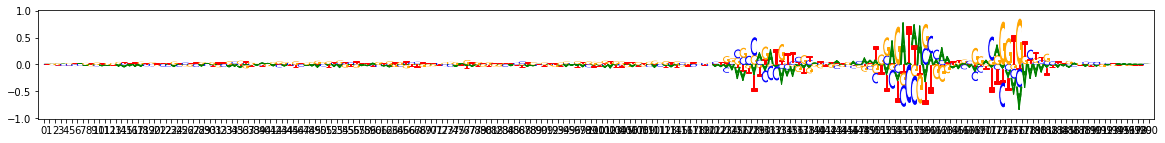

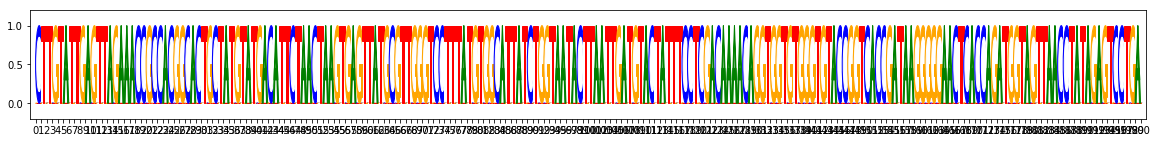

In [6]:
import modisco.visualization
from modisco.visualization import viz_sequence

viz_sequence.plot_weights(task_to_scores['task0'][0])
viz_sequence.plot_weights(task_to_hyp_scores['task0'][0])
viz_sequence.plot_weights(onehot_data[0])

## Run TF-MoDISco

TF-MoDISco first identifies seqlets, then splits the seqlets into "metaclusters" according to their pattern of activity across all the tasks, and then performs clustering within each task. Since there are 3 tasks, there are 27 possible metaclusters (consisting of a +1, -1 or 0 for each task). Consistent with the simulation, the [+1, +1, 0], [+1, 0, +1], [0, 0, +1] and [0, +1, 0] metaclusters turn up motifs.

To demonstrate customization, the code below has slight modifications from default settings in the following ways:
- Because the TAL and GATA motifs are relatively short compared to something like CTCF, it uses a sliding window size of 15 (rather than the default of 21) and flanks of 5 (rather than the default of 10). The sliding window size and flanks should be adjusted according to the expected length of the core motif and its flanks. If the window size or flank sizes are too long, you risk picking up more noise.
- During the seqlet clustering, motifs are trimmed to the central `trim_to_window_size` bp with the highest importance. `trim_to_window_size` is set to 10 rather than the default of 30. After the trimming is done, the seqlet is expanded on either side by `initial_flank_to_add`. This is set to 3 rather than the default of 10.
- The `final_min_cluster_size` is set to 60 rather than the default of 30. This is used to filter out small clusters with relatively weak support (in this case, fewer than 50 seqlets).
- It uses kmers of length 5 with 1 gap and no mismatches to compute the "quick and dirty" affinity matrix across all seqlets. The "quick and dirty" affinity matrix is used both for noise filtering and as a first pass to speed up computation of the continuous jaccard affinity matrix (the latter affinities are only computed between seqlets deemed to be close together by the "quick and dirty" method). I made the kmer length smaller to keep memory usage on the GPU down when testing on my macbook pro. The default is to use kmers of length 8 with 3 gaps and 2 mismatches, and this works fine on more modern GPUs than the one in my 4-year-old macbook.
- `target_seqlet_fdr` controls the noisiness of the seqelts. For a particular task, "significant" seqlets are identified by fitting a laplace distribution to the left and right tails of the values obtained after smoothing the importance scores with a window of size `sliding_window_size`. This laplace distribution is assumed to represent the null distribution of random seqlet importance scores. A threshold is then identified such that the false discovery rate (computed as the ratio of the expected number of seqlets according to the laplace null to the observed number of seqlets above the threshold) is less that `target_seqlet_fdr`. This is what is meant by "Est. FDR" printed in the logs below. If "Est. FDR" is above the target threshold, that means there was no significant increase in the number of seqlets relative to the null. You'll see below that "Est. FDR" for negative scores for any task is above this threshold, which fits with the simulation because there were no "negative set" motifs.

On task task0
Computing windowed sums on original
Generating null dist
peak(mu)= -0.022370883534662427
Computing threshold
Thresholds from null dist were -1.0124836  and  0.88282955
Final raw thresholds are -1.0124836  and  0.88282955
Final transformed thresholds are -0.8494086021505376  and  0.8381182795698925


TF-MoDISco is using the TensorFlow backend.


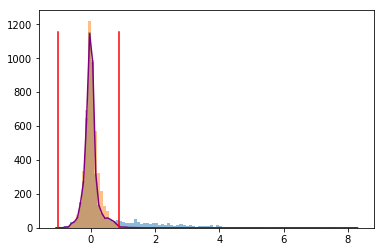

Got 200 coords
On task task1
Computing windowed sums on original
Generating null dist
peak(mu)= -0.00025500369607470933
Computing threshold
Thresholds from null dist were -0.9181976  and  0.4994531
Final raw thresholds are -0.9181976  and  0.4994531
Final transformed thresholds are -0.9040322580645161  and  0.8672043010752688


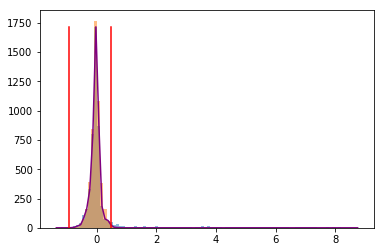

Got 162 coords
On task task2
Computing windowed sums on original
Generating null dist
peak(mu)= -0.0034696256672032176
Computing threshold
Thresholds from null dist were -0.50539863  and  0.6281718
Final raw thresholds are -0.50539863  and  0.6281718
Final transformed thresholds are -0.8540860215053764  and  0.8682795698924731


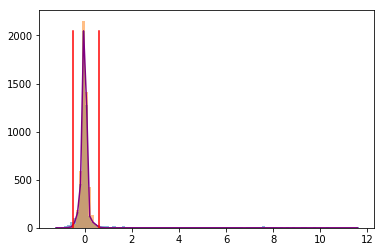

Got 183 coords
After resolving overlaps, got 292 seqlets
Across all tasks, the weakest transformed threshold used was: 0.8381181795698925
292 identified in total
2 activity patterns with support >= 100 out of 27 possible patterns
Metacluster sizes:  [115, 105]
Idx to activities:  {0: '1,0,1', 1: '1,1,0'}
On metacluster 1
Metacluster size 105
Relevant tasks:  ('task0', 'task1')
Relevant signs:  (1, 1)
TfModiscoSeqletsToPatternsFactory: seed=1234
(Round 1) num seqlets: 105
(Round 1) Computing coarse affmat
Beginning embedding computation
Computing embeddings
Finished embedding computation in 0.53 s
Starting affinity matrix computations
Normalization computed in 0.0 s
Cosine similarity mat computed in 0.0 s
Normalization computed in 0.0 s
Cosine similarity mat computed in 0.0 s
Finished affinity matrix computations in 0.0 s
(Round 1) Compute nearest neighbors from coarse affmat
Computed nearest neighbors in 0.0 s
(Round 1) Computing affinity matrix on nearest neighbors
Launching nearest n

Using TensorFlow backend.


Job completed in: 0.6 s
Launching nearest neighbors affmat calculation job
Job completed in: 0.53 s
(Round 1) Computed affinity matrix on nearest neighbors in 1.22 s
Filtered down to 100 of 105
(Round 1) Retained 100 rows out of 105 after filtering
(Round 1) Computing density adapted affmat
[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 100 samples in 0.000s...
[t-SNE] Computed neighbors for 100 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 100 / 100
[t-SNE] Mean sigma: 0.226570
(Round 1) Computing clustering
Beginning preprocessing + Louvain
Wrote graph to binary file in 0.00883197784424 seconds
Running Louvain modularity optimization
Louvain completed 200 runs in 1.95681500435 seconds
Wrote graph to binary file in 0.00674819946289 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.664323
After 4 runs, maximum modularity is Q = 0.669208
After 9 runs, maximum modularity is Q = 0.671176
Louvain completed 59 r

[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    1.8s finished


Job completed in: 0.41 s
Launching nearest neighbors affmat calculation job
Job completed in: 0.53 s
(Round 2) Computed affinity matrix on nearest neighbors in 1.02 s
Not applying filtering for rounds above first round
(Round 2) Computing density adapted affmat
[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 87 samples in 0.000s...
[t-SNE] Computed neighbors for 87 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 87 / 87
[t-SNE] Mean sigma: 0.231107
(Round 2) Computing clustering
Beginning preprocessing + Louvain
Wrote graph to binary file in 0.00756001472473 seconds
Running Louvain modularity optimization
Louvain completed 200 runs in 1.96468305588 seconds
Wrote graph to binary file in 0.00619196891785 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.675189
After 2 runs, maximum modularity is Q = 0.676486
After 9 runs, maximum modularity is Q = 0.690137
Louvain completed 59 runs in 0.984433889389 seconds
Prep

[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    1.8s finished


Computing pattern to pattern distances
Collapsing 3 & 4 with prob 1.970163312617751e-05 and sim 1.9537584792266824
Collapsing 3 & 5 with prob 7.335715572634016e-05 and sim 1.9425399918536537
Collapsing 0 & 2 with prob 6.62906136193609e-05 and sim 1.9253770076900385
Collapsing 4 & 5 with prob 5.0653298320087686e-05 and sim 1.9208962504797042
Collapsing 0 & 3 with prob 5.953108704616899e-06 and sim 1.8998034737651792
Collapsing 0 & 4 with prob 1.5474053310437415e-05 and sim 1.8988636517864308
Collapsing 2 & 4 with prob 4.056041188701125e-05 and sim 1.898151091115911
Collapsing 0 & 5 with prob 0.00010014599522904236 and sim 1.8872022707241771
Collapsing 2 & 3 with prob 1.9457450617813703e-05 and sim 1.8788090684535341
Collapsing 2 & 5 with prob 6.654253335885718e-05 and sim 1.835091550030339
Trimmed 0 out of 24
Trimmed 0 out of 35
Trimmed 0 out of 29
Trimmed 0 out of 64
On merging iteration 2
Computing pattern to seqlet distances
Computing pattern to pattern distances
Got 3 patterns after

[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    1.9s finished


Job completed in: 0.52 s
Launching nearest neighbors affmat calculation job
Job completed in: 0.53 s
(Round 2) Computed affinity matrix on nearest neighbors in 1.14 s
Not applying filtering for rounds above first round
(Round 2) Computing density adapted affmat
[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 88 samples in 0.000s...
[t-SNE] Computed neighbors for 88 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 88 / 88
[t-SNE] Mean sigma: 0.221548
(Round 2) Computing clustering
Beginning preprocessing + Louvain
Wrote graph to binary file in 0.00697088241577 seconds
Running Louvain modularity optimization
Louvain completed 200 runs in 2.06014490128 seconds
Wrote graph to binary file in 0.00537896156311 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.744743
Louvain completed 51 runs in 0.87188911438 seconds
Preproc + Louvain took 2.98074698448 s
Got 6 clusters after round 2
Counts:
{0: 19, 1: 16, 2: 16, 3: 16

[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    1.9s finished


Computing pattern to pattern distances
Collapsing 1 & 4 with prob 2.0229315909443564e-06 and sim 1.9629970573013789
Collapsing 1 & 5 with prob 8.132879849956611e-05 and sim 1.950567493515346
Collapsing 1 & 2 with prob 7.536138774284403e-05 and sim 1.9386329950353822
Collapsing 2 & 4 with prob 6.469756297614975e-06 and sim 1.9346210812493851
Collapsing 2 & 3 with prob 6.379834023013094e-06 and sim 1.9297631795148453
Collapsing 1 & 3 with prob 3.24543374622015e-05 and sim 1.9238754516368435
Collapsing 0 & 1 with prob 7.915687255074337e-05 and sim 1.9205088062908406
Collapsing 4 & 5 with prob 3.900336758972415e-06 and sim 1.9188954283671555
Collapsing 2 & 5 with prob 3.0275642466688666e-05 and sim 1.900183247397217
Collapsing 3 & 5 with prob 5.080187591398142e-06 and sim 1.8994983419737743
Collapsing 0 & 2 with prob 1.2102561498290667e-05 and sim 1.866289697197365
Collapsing 0 & 5 with prob 6.553610001710734e-06 and sim 1.8642345112601697
Collapsing 0 & 3 with prob 2.6360001852182185e-06 

In [7]:
import h5py
import numpy as np
%matplotlib inline
import modisco
reload(modisco)
import modisco.backend
reload(modisco.backend.tensorflow_backend)
reload(modisco.backend)
import modisco.nearest_neighbors
reload(modisco.nearest_neighbors)
import modisco.affinitymat
reload(modisco.affinitymat.core)
reload(modisco.affinitymat.transformers)
import modisco.tfmodisco_workflow.seqlets_to_patterns
reload(modisco.tfmodisco_workflow.seqlets_to_patterns)
import modisco.value_provider
reload(modisco.value_provider)
import modisco.coordproducers
reload(modisco.coordproducers)
import modisco.tfmodisco_workflow.workflow
reload(modisco.tfmodisco_workflow.workflow)
import modisco.aggregator
reload(modisco.aggregator)
import modisco.cluster
reload(modisco.cluster.core)
reload(modisco.cluster.phenograph.core)
reload(modisco.cluster.phenograph.cluster)
import modisco.core
reload(modisco.core)
import modisco.metaclusterers
reload(modisco.metaclusterers)

null_per_pos_scores = modisco.coordproducers.LaplaceNullDist(num_to_samp=5000)
tfmodisco_results = modisco.tfmodisco_workflow.workflow.TfModiscoWorkflow(
                    #Slight modifications from the default settings
                    sliding_window_size=15,
                    flank_size=5,
                    target_seqlet_fdr=0.2,
                    seqlets_to_patterns_factory=
                     modisco.tfmodisco_workflow.seqlets_to_patterns.TfModiscoSeqletsToPatternsFactory(
                        trim_to_window_size=15,
                        initial_flank_to_add=5,
                        kmer_len=5, num_gaps=1,
                        num_mismatches=0,
                        final_min_cluster_size=60)
                )(
                 task_names=["task0", "task1", "task2"],
                 contrib_scores=task_to_scores,
                 hypothetical_contribs=task_to_hyp_scores,
                 one_hot=onehot_data,
                 null_per_pos_scores = null_per_pos_scores)

## Save Results

In [8]:
import h5py
import modisco.util
reload(modisco.util)
!rm results.hdf5
grp = h5py.File("results.hdf5")
tfmodisco_results.save_hdf5(grp)
grp.close()

## Print results

Metaclusters heatmap


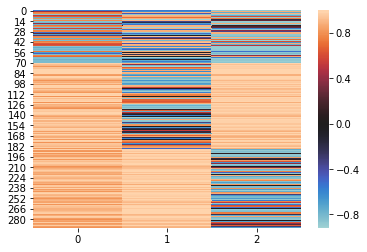

metacluster_0
activity pattern: [1 0 1]
metacluster_0 pattern_0
total seqlets: 82
Task 0 hypothetical scores:


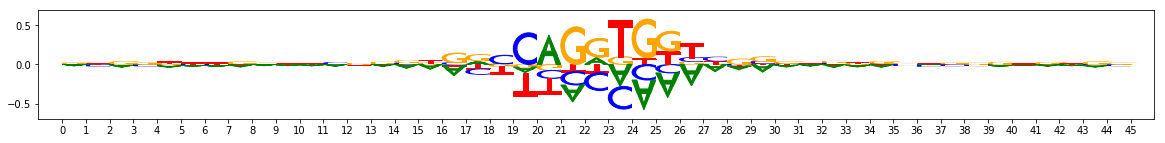

Task 0 actual importance scores:


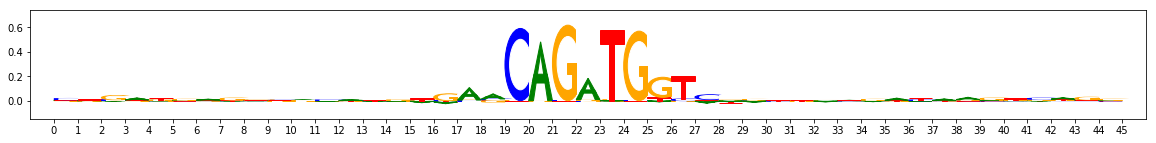

Task 1 hypothetical scores:


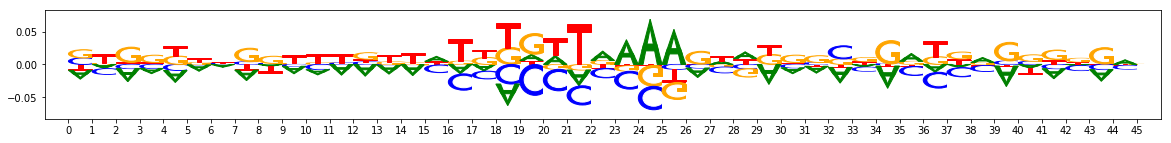

Task 1 actual importance scores:


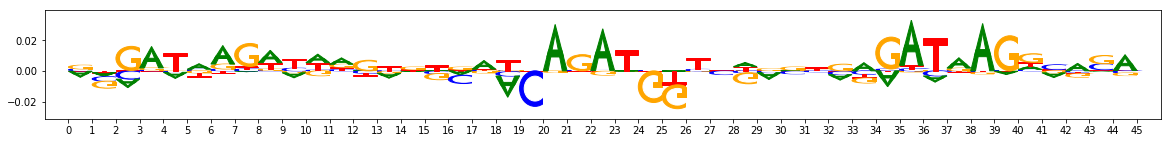

Task 2 hypothetical scores:


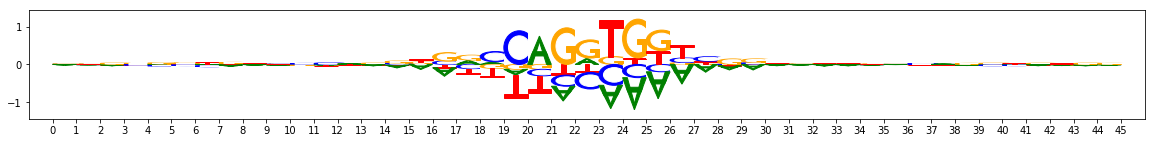

Task 2 actual importance scores:


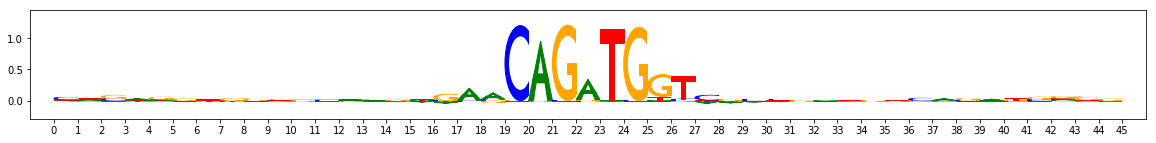

onehot, fwd and rev:


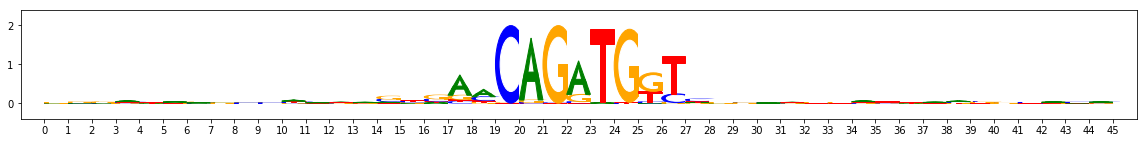

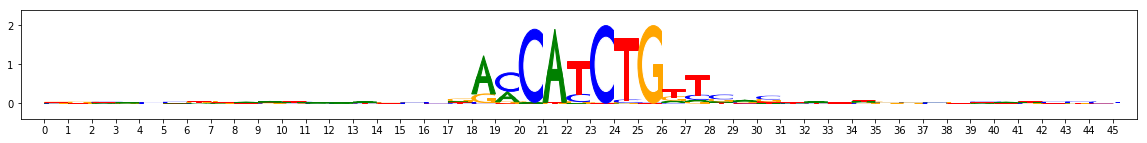

metacluster_1
activity pattern: [1 1 0]
metacluster_1 pattern_0
total seqlets: 78
Task 0 hypothetical scores:


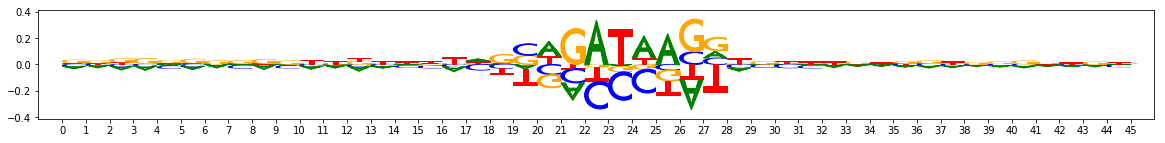

Task 0 actual importance scores:


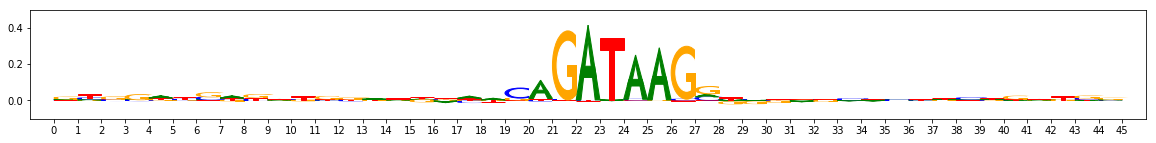

Task 1 hypothetical scores:


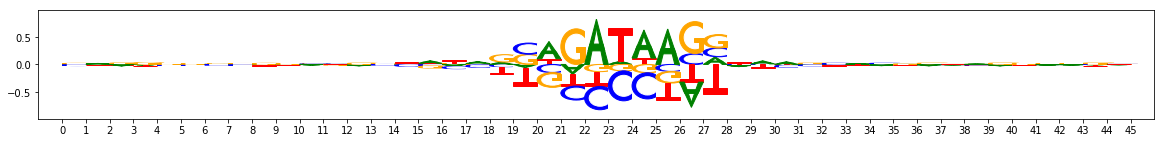

Task 1 actual importance scores:


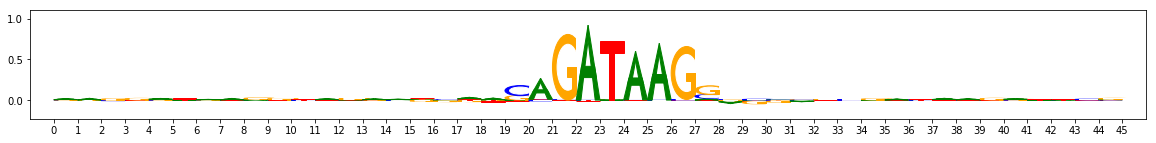

Task 2 hypothetical scores:


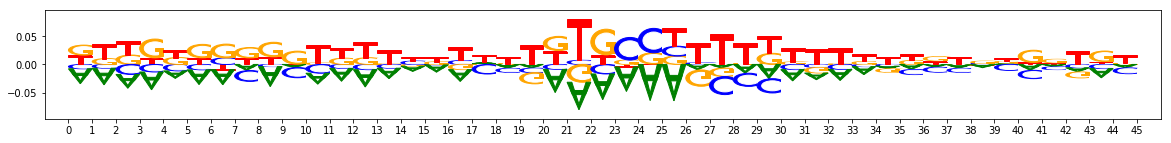

Task 2 actual importance scores:


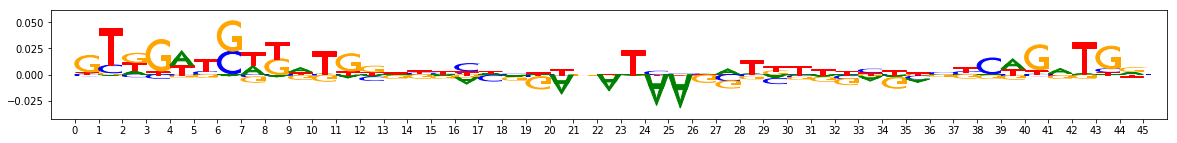

onehot, fwd and rev:


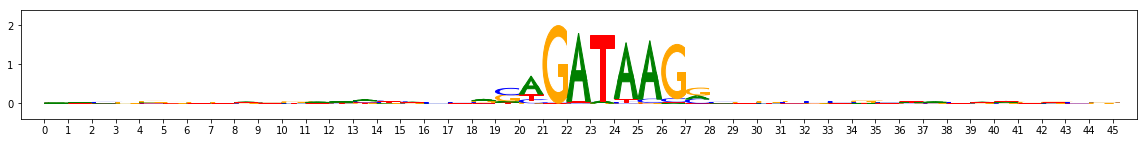

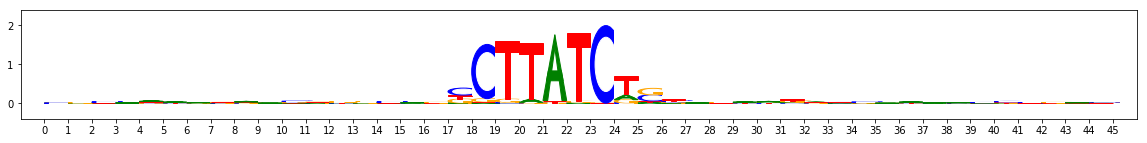

In [9]:
from collections import Counter
from modisco.visualization import viz_sequence
reload(viz_sequence)
from matplotlib import pyplot as plt

import modisco.affinitymat.core
reload(modisco.affinitymat.core)
import modisco.cluster.phenograph.core
reload(modisco.cluster.phenograph.core)
import modisco.cluster.phenograph.cluster
reload(modisco.cluster.phenograph.cluster)
import modisco.cluster.core
reload(modisco.cluster.core)
import modisco.aggregator
reload(modisco.aggregator)

hdf5_results = h5py.File("results.hdf5","r")

print("Metaclusters heatmap")
import seaborn as sns
activity_patterns = np.array(hdf5_results['metaclustering_results']['attribute_vectors'])[
                    np.array(
        [x[0] for x in sorted(
                enumerate(hdf5_results['metaclustering_results']['metacluster_indices']),
               key=lambda x: x[1])])]
sns.heatmap(activity_patterns, center=0)
plt.show()

metacluster_names = [
    x.decode("utf-8") for x in 
    list(hdf5_results["metaclustering_results"]
         ["all_metacluster_names"][:])]

all_patterns = []

for metacluster_name in metacluster_names:
    print(metacluster_name)
    metacluster_grp = (hdf5_results["metacluster_idx_to_submetacluster_results"]
                                   [metacluster_name])
    print("activity pattern:",metacluster_grp["activity_pattern"][:])
    all_pattern_names = [x.decode("utf-8") for x in 
                         list(metacluster_grp["seqlets_to_patterns_result"]
                                             ["patterns"]["all_pattern_names"][:])]
    if (len(all_pattern_names)==0):
        print("No motifs found for this activity pattern")
    for pattern_name in all_pattern_names:
        print(metacluster_name, pattern_name)
        all_patterns.append((metacluster_name, pattern_name))
        pattern = metacluster_grp["seqlets_to_patterns_result"]["patterns"][pattern_name]
        print("total seqlets:",len(pattern["seqlets_and_alnmts"]["seqlets"]))
        background = np.array([0.27, 0.23, 0.23, 0.27])
        print("Task 0 hypothetical scores:")
        viz_sequence.plot_weights(pattern["task0_hypothetical_contribs"]["fwd"])
        print("Task 0 actual importance scores:")
        viz_sequence.plot_weights(pattern["task0_contrib_scores"]["fwd"])
        print("Task 1 hypothetical scores:")
        viz_sequence.plot_weights(pattern["task1_hypothetical_contribs"]["fwd"])
        print("Task 1 actual importance scores:")
        viz_sequence.plot_weights(pattern["task1_contrib_scores"]["fwd"])
        print("Task 2 hypothetical scores:")
        viz_sequence.plot_weights(pattern["task2_hypothetical_contribs"]["fwd"])
        print("Task 2 actual importance scores:")
        viz_sequence.plot_weights(pattern["task2_contrib_scores"]["fwd"])
        print("onehot, fwd and rev:")
        viz_sequence.plot_weights(viz_sequence.ic_scale(np.array(pattern["sequence"]["fwd"]),
                                                        background=background)) 
        viz_sequence.plot_weights(viz_sequence.ic_scale(np.array(pattern["sequence"]["rev"]),
                                                        background=background)) 
        
hdf5_results.close()

## Load the saved hdf5 file

Load the results object from the saved file

In [10]:
import h5py
import numpy as np
from collections import OrderedDict
import modisco.util
import modisco.core
reload(modisco.core)
import modisco.metaclusterers
reload(modisco.metaclusterers)
import modisco.value_provider
reload(modisco.value_provider)
import modisco.coordproducers
reload(modisco.coordproducers)
import modisco.tfmodisco_workflow.seqlets_to_patterns
import modisco.tfmodisco_workflow
reload(modisco.tfmodisco_workflow.seqlets_to_patterns)
reload(modisco.tfmodisco_workflow)
from modisco.tfmodisco_workflow import workflow
reload(workflow)

track_set = modisco.tfmodisco_workflow.workflow.prep_track_set(
                task_names=tasks,
                contrib_scores=task_to_scores,
                hypothetical_contribs=task_to_hyp_scores,
                one_hot=onehot_data)

grp = h5py.File("results.hdf5","r")
loaded_tfmodisco_results =\
    workflow.TfModiscoResults.from_hdf5(grp, track_set=track_set)
grp.close()

## Prepare hit scorers

Prepare a seqlet scorer (`max_rank_based_pattern_scorer`)

In [11]:
from modisco import affinitymat
reload(affinitymat.core)
reload(affinitymat)
from modisco import hit_scoring
reload(hit_scoring.fast_hit_scoring)
reload(hit_scoring)
from collections import OrderedDict

task_names = ["task0", "task1", "task2"]

seqlet_size_to_score_with = 25

metacluster_idx_to_scorer = OrderedDict()

all_pattern_scorers = []
all_pattern_names = []

for metacluster_name in\
    sorted(loaded_tfmodisco_results
           .metacluster_idx_to_submetacluster_results.keys()):
    submetacluster_results =(
        loaded_tfmodisco_results
            .metacluster_idx_to_submetacluster_results[metacluster_name])
    activity_pattern = submetacluster_results.activity_pattern
    relevant_task_names = [task_name for (task_name,x) in
                           zip(task_names, activity_pattern) if np.abs(x) != 0]
    
    patterns_in_submetacluster =\
        submetacluster_results.seqlets_to_patterns_result.patterns
 
    pattern_comparison_settings = affinitymat.core.PatternComparisonSettings(
        track_names=([x+"_contrib_scores" for x in relevant_task_names]
                     +[x+"_hypothetical_contribs" for x in relevant_task_names]),
        track_transformer=affinitymat.L1Normalizer(),
        min_overlap=0.7)

    pattern_to_seqlets_sim_computer = hit_scoring.PatternsToSeqletsSimComputer(
        pattern_comparison_settings=pattern_comparison_settings,
        cross_metric_computer=\
            affinitymat.core.ParallelCpuCrossMetricOnNNpairs(
                n_cores=1,
                cross_metric_single_region=
                    affinitymat.core.CrossContinJaccardSingleRegionWithArgmax(),
                verbose=False),
        seqlet_trimmer=modisco.hit_scoring.SeqletTrimToBestWindow(
                        window_size=seqlet_size_to_score_with,
                        track_names=[x+"_contrib_scores" for x
                                     in relevant_task_names]))

    #Get a list of scorers for all the patterns in the metacluster
    metacluster_pattern_scorers = []
    for pattern_idx, pattern in\
        enumerate(submetacluster_results.
                   seqlets_to_patterns_result.patterns):
        metacluster_idx = int(metacluster_name.split("_")[1])
        all_pattern_names.append("metacluster_"+str(metacluster_idx)
                             +",pattern_"+str(pattern_idx))
        pattern_scorer = hit_scoring.RankBasedPatternScorer(
                aggseqlets=pattern,
                patterns_to_seqlets_sim_computer=
                    pattern_to_seqlets_sim_computer)
        metacluster_pattern_scorers.append(pattern_scorer)
        all_pattern_scorers.append(pattern_scorer)
    #This is the final scorer for the metacluster;
    # it takes the maximum score produced by all the
    # individual scorers
    max_rank_based_pattern_scorer = hit_scoring.MaxRankBasedPatternScorer(
                                        pattern_scorers=metacluster_pattern_scorers)
    metacluster_idx_to_scorer[metacluster_idx] = max_rank_based_pattern_scorer
cross_metacluster_scorer = hit_scoring.MaxRankBasedPatternScorer(
                                pattern_scorers=all_pattern_scorers)

Test it out...prepare a bunch of seqlets to score using the original patterns

In [12]:
from sklearn.metrics import confusion_matrix
all_patterns = [x for y in
                  sorted(loaded_tfmodisco_results
                  .metacluster_idx_to_submetacluster_results.keys())
                  for x in
                   loaded_tfmodisco_results
                   .metacluster_idx_to_submetacluster_results[y]
                   .seqlets_to_patterns_result.patterns]
seqlets_to_score = []
seqlets_to_score_true_labels = []
for i,pattern in enumerate(all_patterns):
    seqlets_to_score.extend(pattern.seqlets)
    seqlets_to_score_true_labels.extend(
        [i for x in pattern.seqlets])

Now score the seqlets (we will use the cross-metacluster scorer here)

In [13]:
pattern_scores_for_each_seqlet = cross_metacluster_scorer(seqlets_to_score)
print(pattern_scores_for_each_seqlet[:5])
seqlets_to_score_predicted_labels =\
    [x.pattern_idx for x in pattern_scores_for_each_seqlet]
confusion_mat = confusion_matrix(y_true = seqlets_to_score_true_labels,
                                 y_pred = seqlets_to_score_predicted_labels)
print(all_pattern_names)
print(confusion_mat.astype("float")/np.sum(confusion_mat,axis=1)[:,None])

[RankNormedScoreResults(pattern_idx=0, percnormed_score=0.9512195121951219, score=0.6312267278280181, offset=0.0, revcomp=0.0), RankNormedScoreResults(pattern_idx=0, percnormed_score=0.36585365853658536, score=0.48199815813829505, offset=0.0, revcomp=0.0), RankNormedScoreResults(pattern_idx=0, percnormed_score=0.8292682926829268, score=0.6045231291385648, offset=0.0, revcomp=0.0), RankNormedScoreResults(pattern_idx=1, percnormed_score=0.5384615384615384, score=0.4876993788539074, offset=19.0, revcomp=0.0), RankNormedScoreResults(pattern_idx=0, percnormed_score=0.6341463414634146, score=0.5535650315103232, offset=0.0, revcomp=0.0)]
['metacluster_0,pattern_0', 'metacluster_1,pattern_0']
[[0.97560976 0.02439024]
 [0.02564103 0.97435897]]


## Obtain seqlets from data

In [14]:
per_position_contrib_scores = OrderedDict([                             
    (x, [np.sum(s,axis=1) for s in task_to_scores[x]]) for x in tasks])
seqlets_from_data =(
    loaded_tfmodisco_results.multitask_seqlet_creation_results.multitask_seqlet_creator(
        task_name_to_score_track=per_position_contrib_scores,  
        null_tracks=null_per_pos_scores,
        track_set=track_set,
        task_name_to_tnt_results=
            loaded_tfmodisco_results
             .multitask_seqlet_creation_results
             .task_name_to_tnt_results,
        )).final_seqlets

On task task0
Computing windowed sums on original
Generating null dist
peak(mu)= -0.022370883534662427
Got 200 coords
On task task1
Computing windowed sums on original
Generating null dist
peak(mu)= -0.00025500369607470933
Got 162 coords
On task task2
Computing windowed sums on original
Generating null dist
peak(mu)= -0.0034696256672032176
Got 183 coords
After resolving overlaps, got 292 seqlets


## Map seqlets to metacluster, then to a pattern

Example seqlets for metacluster -1 (unmapped)


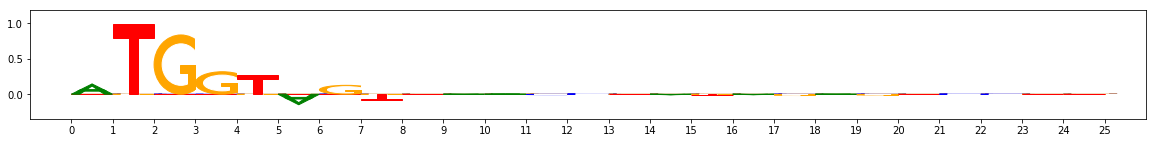

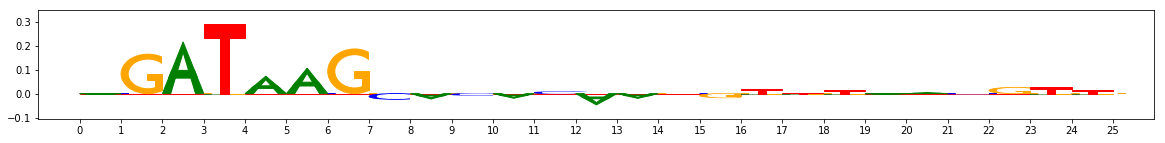


Metacluster idx 0 

TOP MATCHES
RankNormedScoreResults(pattern_idx=0, percnormed_score=1.0, score=0.648643707267138, offset=12.0, revcomp=0.0)


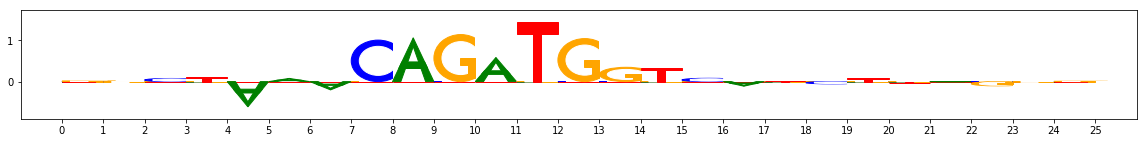

RankNormedScoreResults(pattern_idx=0, percnormed_score=0.9878048780487805, score=0.646410718918468, offset=7.0, revcomp=0.0)


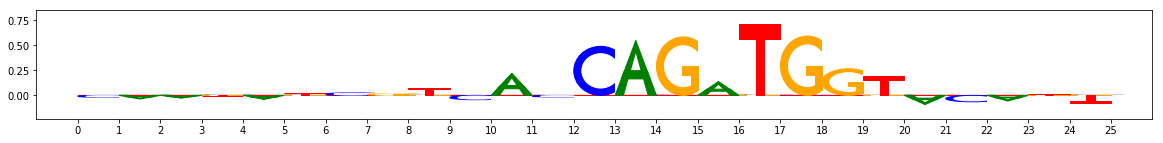

WORST MATCHES
RankNormedScoreResults(pattern_idx=0, percnormed_score=0.0, score=0.1666957540495901, offset=9.0, revcomp=0.0)


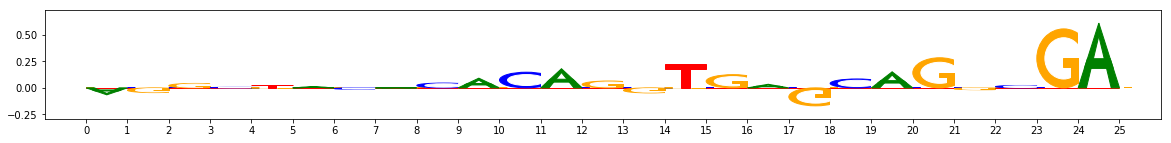

RankNormedScoreResults(pattern_idx=0, percnormed_score=0.012195121951219513, score=0.2568686083950155, offset=9.0, revcomp=0.0)


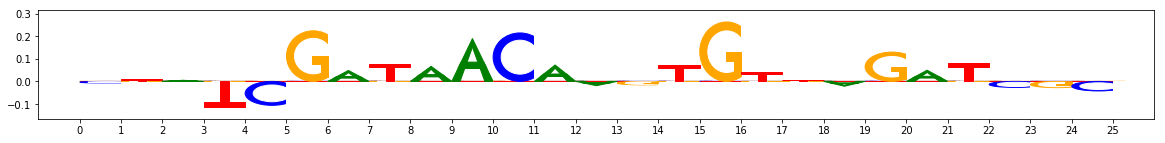


Metacluster idx 1 

TOP MATCHES
RankNormedScoreResults(pattern_idx=0, percnormed_score=1.0, score=0.6254047628103442, offset=14.0, revcomp=0.0)


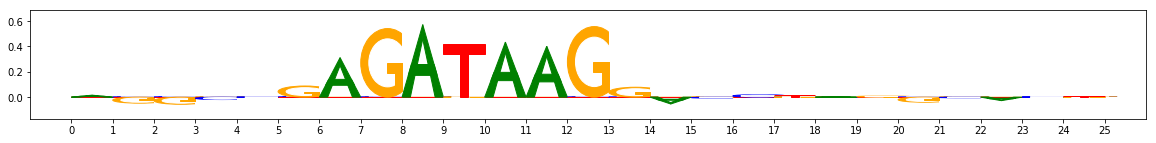

RankNormedScoreResults(pattern_idx=0, percnormed_score=0.9871794871794872, score=0.6199305345588327, offset=8.0, revcomp=0.0)


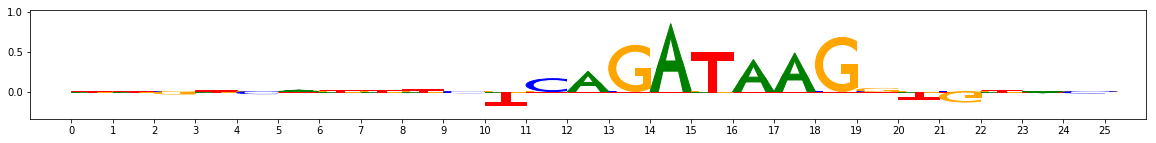

WORST MATCHES
RankNormedScoreResults(pattern_idx=0, percnormed_score=0.02564102564102564, score=0.24085041323370954, offset=8.0, revcomp=0.0)


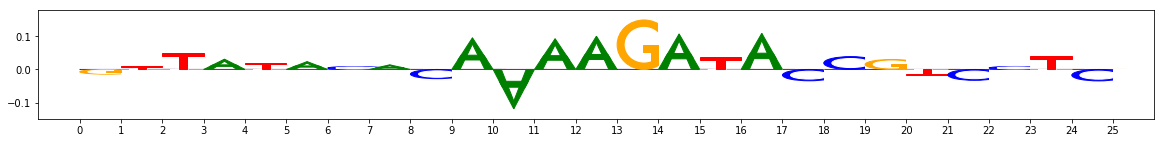

RankNormedScoreResults(pattern_idx=0, percnormed_score=0.02564102564102564, score=0.2167295878860862, offset=22.0, revcomp=0.0)


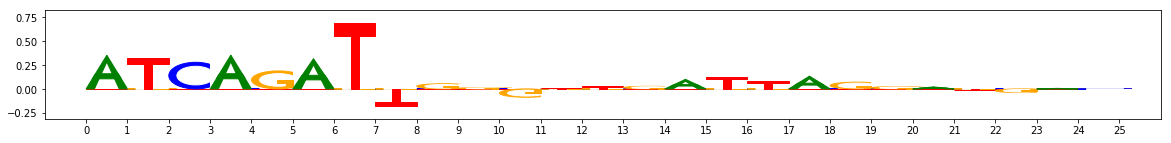

In [15]:
from collections import defaultdict, OrderedDict

metacluster_indices = loaded_tfmodisco_results.metaclustering_results.metaclusterer.transform(
                                    seqlets_from_data).metacluster_indices

metacluster_idx_to_seqlets = defaultdict(list)
for a_seqlet, metacluster_idx in zip(seqlets_from_data, metacluster_indices):
    metacluster_idx_to_seqlets[metacluster_idx].append(a_seqlet)

#visualize a few seqlets from each metacluster
num_to_viz = 2
for metacluster_idx in metacluster_idx_to_seqlets:
    if (metacluster_idx == -1):
        print("Example seqlets for metacluster -1 (unmapped)")
        for a_seqlet in metacluster_idx_to_seqlets[metacluster_idx][:num_to_viz]:
            viz_sequence.plot_weights(a_seqlet["task0_contrib_scores"].fwd)

#map to patterns within each metacluster
metacluster_to_seqlet_pattern_matches = OrderedDict() 
for metacluster_idx in metacluster_idx_to_scorer:
    print("\nMetacluster idx",metacluster_idx,"\n")
    metacluster_seqlets = metacluster_idx_to_seqlets[metacluster_idx]
    seqlet_pattern_matches = metacluster_idx_to_scorer[metacluster_idx](metacluster_seqlets)
    metacluster_to_seqlet_pattern_matches[metacluster_idx] = seqlet_pattern_matches
    sorted_seqlet_pattern_matches = sorted(zip(seqlet_pattern_matches, metacluster_seqlets),
                                           key=lambda x: -x[0].percnormed_score)
    print("TOP MATCHES")
    for i in range(num_to_viz):
        print(sorted_seqlet_pattern_matches[i][0])
        viz_sequence.plot_weights(sorted_seqlet_pattern_matches[i][1]["task0_contrib_scores"].fwd)
    print("WORST MATCHES")
    for i in range(num_to_viz):
        print(sorted_seqlet_pattern_matches[-(i+1)][0])
        viz_sequence.plot_weights(sorted_seqlet_pattern_matches[-(i+1)][1]["task0_contrib_scores"].fwd)
        

The code below is a test to check that reverse complements also work

In [16]:
#The rc_track_set and rc_seqlets_from_data is just there to
# test whether reverse complements are working correctly
rc_track_set = modisco.tfmodisco_workflow.workflow.prep_track_set(
                task_names=tasks,
                contrib_scores=dict([(key, np.array(val)[:,::-1,::-1]) for
                                     (key,val) in task_to_scores.items()]),
                hypothetical_contribs=dict([(key, np.array(val)[:,::-1,::-1]) for
                                            (key,val) in task_to_hyp_scores.items()]),
                one_hot=onehot_data)
rc_seqlets_from_data =(
    loaded_tfmodisco_results.multitask_seqlet_creation_results.multitask_seqlet_creator(
        task_name_to_score_track={key: np.array(val)[:,::-1] for
                                  (key,val) in per_position_contrib_scores.items()},
        null_tracks=null_per_pos_scores,
        track_set=rc_track_set,
        task_name_to_tnt_results=
            loaded_tfmodisco_results
             .multitask_seqlet_creation_results
             .task_name_to_tnt_results)).final_seqlets

rc_metacluster_indices = loaded_tfmodisco_results.metaclustering_results.metaclusterer.transform(
                                    rc_seqlets_from_data).metacluster_indices
assert np.max(np.abs(np.array(rc_metacluster_indices)
                     - np.array(metacluster_indices)))==0

rc_metacluster_idx_to_seqlets = defaultdict(list)
for a_seqlet, metacluster_idx in zip(rc_seqlets_from_data, rc_metacluster_indices):
    rc_metacluster_idx_to_seqlets[metacluster_idx].append(a_seqlet)

#map to patterns within each metacluster
rc_metacluster_to_seqlet_pattern_matches = OrderedDict() 
for metacluster_idx in metacluster_idx_to_scorer:
    rc_metacluster_to_seqlet_pattern_matches[metacluster_idx] =\
        metacluster_idx_to_scorer[metacluster_idx](rc_metacluster_idx_to_seqlets[metacluster_idx])
        
#check that the scores are compatible
for metacluster_idx in rc_metacluster_to_seqlet_pattern_matches:
    rc_seqlet_pattern_matches = rc_metacluster_to_seqlet_pattern_matches[metacluster_idx]
    seqlet_pattern_matches = metacluster_to_seqlet_pattern_matches[metacluster_idx]
    for (rc_match, fwd_match) in zip(rc_seqlet_pattern_matches, seqlet_pattern_matches):
        #atol = 0.02 because small numerical differences in the match score
        # can shif the percentile ranking around
        if (np.isclose(rc_match.percnormed_score,fwd_match.percnormed_score,atol=0.02) == False):
            print(rc_match, fwd_match)
            assert False
        assert np.isclose(rc_match.score, fwd_match.score)
        #In the revcomp case,
        # the value of the offset would be the same as the fwd's distance
        # from the end of the seqlet to the end of the pattern.
        # At the time of writing, 45 bp was the length of the pattern and
        # 25 bp was the length of the seqlet; 45 - (offset + 25) = 20-offset
        assert rc_match.offset == 20-fwd_match.offset
        assert rc_match.revcomp == 1.0
        assert fwd_match.revcomp == 0.0

On task task0
Computing windowed sums on original
Generating null dist
peak(mu)= -0.022370818031020465
Got 200 coords
On task task1
Computing windowed sums on original
Generating null dist
peak(mu)= -0.0002550950227305296
Got 162 coords
On task task2
Computing windowed sums on original
Generating null dist
peak(mu)= -0.003900640147738159
Got 183 coords
After resolving overlaps, got 292 seqlets
